['L_V1', 'L_3b'] ['L_FEF']
{0: 5, 9: 5, 8: 5}
visual start 0 visual end 5
somatosensory start 12 somatosensory end 17
         Rule  Epoch    Spread  SensoryDist
0     fdgo_s1  stim1  0.269196     3.817276
1     fdgo_s1    go1  0.404779     5.663696
2     fdgo_v1  stim1  0.423305     5.980785
3     fdgo_v1    go1  0.606028     8.505545
4  reactgo_s1    go1  0.174034     2.434960


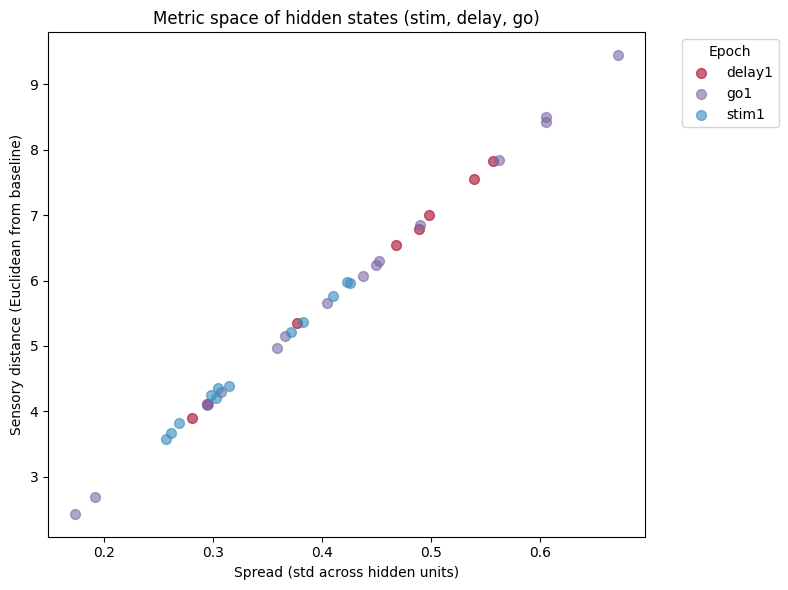

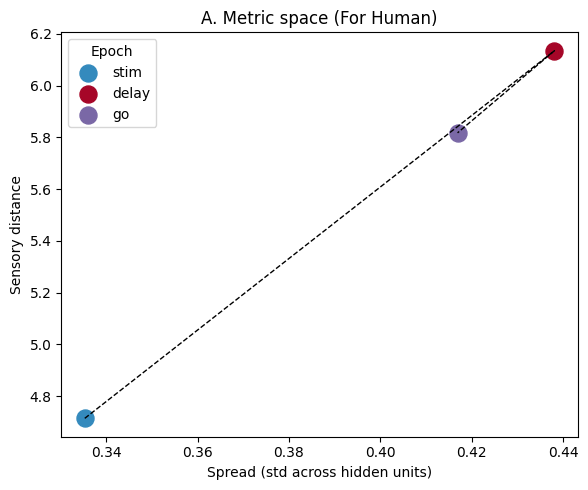

In [1]:
import sys, pathlib
import os, pickle, random, copy
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# Repo setup
# ----------------------------
ROOT = pathlib.Path.cwd().resolve()
while ROOT.name != "Implementation_human_mouse" and ROOT != ROOT.parent:
    ROOT = ROOT.parent
if ROOT.name != "Implementation_human_mouse":
    raise RuntimeError("Could not find repo root 'Implementation_human_mouse'")

sys.path.insert(0, str(ROOT))
from src.pytorch_models import LightningRNNModule
from src.dataset import RuleBasedTasks, collate_fn

# ----------------------------
# Model checkpoint
# ----------------------------
run_folder = "skilled-surf-178_fdgo_s1_fdgo_v1_reactgo_s1_reactgo_v1_delaygo_s1_delaygo_v1_fdanti_s1_fdanti_v1_reactanti_s1_reactanti_v1_delayanti_s1_delayanti_v1_dmsgo_dmsnogo_dmcgo_dmcnogo_V1_5_FEF_5_3b_5"
checkpoint_dir = ROOT / "saved_models" / "cernn" / run_folder
if not checkpoint_dir.exists():
    raise FileNotFoundError(checkpoint_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_files = sorted(f for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt"))
ckpt_path = os.path.join(checkpoint_dir, ckpt_files[0])
with open(os.path.join(checkpoint_dir, "hp_pl_module.pkl"), "rb") as f:
    hp_pl_module = pickle.load(f)
with open(os.path.join(checkpoint_dir, "task_hp.pkl"), "rb") as f:
    task_hp = pickle.load(f)

model = LightningRNNModule.load_from_checkpoint(ckpt_path).to(device)
model.eval().freeze()

rule_list = task_hp["rule_trains"]

# ----------------------------
# Config
# ----------------------------
UNITS = 180
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch_gen = torch.Generator().manual_seed(SEED)

task_hp_det = copy.deepcopy(task_hp)
task_hp_det["rng"] = np.random.RandomState(SEED)

loader = DataLoader(
    RuleBasedTasks(task_hp_det, mode="test"),
    batch_size=1,
    collate_fn=collate_fn,
    shuffle=False,
    generator=torch_gen,
)

# ----------------------------
# Epochwise averages
# ----------------------------
epochwise_averages = {}
seen_rules = set()

for batch in loader:
    rule = batch.rule
    if rule in seen_rules:
        if len(seen_rules) == len(rule_list):
            break
        continue
    seen_rules.add(rule)

    batch.x = batch.x.to(device)
    with torch.no_grad():
        _, hidden = model.eval_step(batch)

    h_np = hidden[:, 0, :].cpu().numpy()  # (T, UNITS)
    h_proc = h_np

    epochwise_averages[rule] = {}
    for ep, (s, e) in batch.epochs.items():
        s = 0 if s is None else int(s)
        e = h_proc.shape[0] if e is None else int(e)
        epochwise_averages[rule][ep] = h_proc[s:e].mean(axis=0)

# ----------------------------
# Build metrics DataFrame
# ----------------------------
rows = []
for rule, ep_dict in epochwise_averages.items():
    baseline = ep_dict.get("fix1", np.zeros(len(next(iter(ep_dict.values())))))
    for ep_name, vec in ep_dict.items():
        if not any(ep_name.startswith(e) for e in ["stim", "delay", "go"]):
            continue
        vec_delta = vec - baseline
        spread = np.std(vec_delta)                    # Spread = std across hidden units
        sens_dist = np.linalg.norm(vec_delta)         # Sensory distance = Euclidean from baseline
        rows.append(dict(Rule=rule, Epoch=ep_name, Spread=spread, SensoryDist=sens_dist))

df_metrics = pd.DataFrame(rows)
print(df_metrics.head())

# ----------------------------
# Metric space plot
# ----------------------------
epoch_palette = {"stim": "#348ABD", "delay": "#A60628", "go": "#7A68A6"}

plt.figure(figsize=(8, 6))
for ep_name, grp in df_metrics.groupby("Epoch"):
    # use color based on prefix
    color = epoch_palette.get(next((e for e in ["stim","delay","go"] if ep_name.startswith(e)), "grey"))
    plt.scatter(grp["Spread"], grp["SensoryDist"],
                s=50, alpha=0.6, label=ep_name, color=color)

plt.xlabel("Spread (std across hidden units)")
plt.ylabel("Sensory distance (Euclidean from baseline)")
plt.title("Metric space of hidden states (stim, delay, go)")
plt.legend(title="Epoch", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ----------------------------
# Compute centroids for each epoch
# ----------------------------
centroids = df_metrics.groupby(df_metrics["Epoch"].str.extract(r"(stim|delay|go)")[0]).agg({
    "Spread": "mean",
    "SensoryDist": "mean"
}).reindex(["stim", "delay", "go"])  # ensure order

# ----------------------------
# Plot metric space (centroids)
# ----------------------------
epoch_palette = {"stim": "#348ABD", "delay": "#A60628", "go": "#7A68A6"}

plt.figure(figsize=(6, 5))
for ep_name in ["stim", "delay", "go"]:
    plt.scatter(centroids.loc[ep_name, "Spread"],
                centroids.loc[ep_name, "SensoryDist"],
                s=150, color=epoch_palette[ep_name], label=ep_name)

# Connect centroids with lines (trajectory)
plt.plot(centroids["Spread"], centroids["SensoryDist"], color="black", linestyle="--", linewidth=1)


plt.xlabel("Spread (std across hidden units)")
plt.ylabel("Sensory distance")
plt.title("A. Metric space (For Human)")
plt.legend(title="Epoch")
plt.tight_layout()
plt.show()